# Preparing Dataset

In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [11]:
tracks=pd.read_csv("fma-rock-vs-hiphop.csv")

metrics=pd.read_json("echonest-metrics.json", precise_float=True)

echo_tracks = pd.merge(metrics, tracks[['track_id' , 'genre_top']], how='inner', on='track_id')

echo_tracks.head
                    


<bound method NDFrame.head of       track_id  acousticness  danceability    energy  instrumentalness  \
0            2      0.416675      0.675894  0.634476      1.062807e-02   
1            3      0.374408      0.528643  0.817461      1.851103e-03   
2            5      0.043567      0.745566  0.701470      6.967990e-04   
3          134      0.452217      0.513238  0.560410      1.944269e-02   
4          153      0.988306      0.255661  0.979774      9.730057e-01   
...        ...           ...           ...       ...               ...   
4797    124718      0.412194      0.686825  0.849309      6.000000e-10   
4798    124719      0.054973      0.617535  0.728567      7.215700e-06   
4799    124720      0.010478      0.652483  0.657498      7.098000e-07   
4800    124721      0.067906      0.432421  0.764508      1.625500e-06   
4801    124722      0.153518      0.638660  0.762567      5.000000e-10   

      liveness  speechiness    tempo   valence genre_top  
0     0.177647     0.1

# Correlation

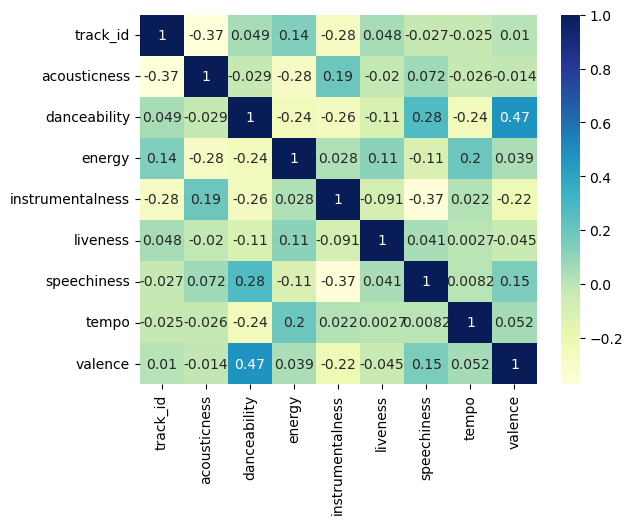

In [19]:
sns.heatmap(data=echo_tracks.corr(),annot=True, cmap='YlGnBu')
plt.show()

# Normalize the feature data

In [31]:
features=echo_tracks.drop(["track_id","genre_top"],axis=1)

labels = echo_tracks.genre_top

scaler=StandardScaler()
scaled_train_features=scaler.fit_transform(features)



# PCA on scaled data

Text(0.5, 0, 'Principal Component')

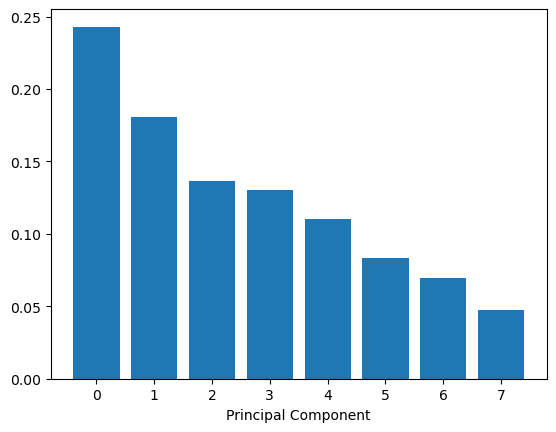

In [26]:
pca=PCA()
pca.fit(scaled_train_features)
exp_variance=pca.explained_variance_ratio_

plt.bar(range(pca.n_components_), exp_variance)
plt.xlabel("Principal Component")

# Further Vizualization of PCA

[0.24297674 0.4234199  0.55992299 0.68986388 0.80042636 0.88344881
 0.95268664 1.        ]


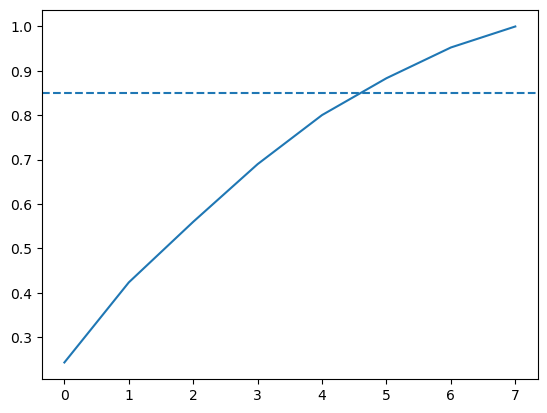

In [34]:
cum_exp_variance = np.cumsum(exp_variance)
print(cum_exp_variance)

plt.plot(cum_exp_variance)
plt.axhline(y=0.85, linestyle="--")

n_components=6

pca=PCA(n_components,random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)


# Train Decision Tree

In [35]:
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

pred_labels_tree = tree.predict(test_features)

# Compare decision tree to a logistic regression

In [38]:
logreg=LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_log=logreg.predict(test_features)

class_rep_tree=classification_report(test_labels,pred_labels_tree)
class_rep_log=classification_report(test_labels,pred_labels_log)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)


Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



# Balance data for better performance

In [49]:
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only= echo_tracks.loc[echo_tracks['genre_top']== 'Rock']


rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

rock_hop_bal = pd.concat([rock_only, hop_only])

features=rock_hop_bal.drop(['track_id','genre_top'], axis=1)
labels=rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

# Does balancing dataset improve model bias?

In [50]:
tree = DecisionTreeClassifier()
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)


logreg = LogisticRegression()
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)


print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_tree))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.75      0.73      0.74       230
        Rock       0.73      0.75      0.74       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.75      0.73      0.74       230
        Rock       0.73      0.75      0.74       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455



# Using cross-validation to evaluate models

In [51]:
kf=KFold(n_splits=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

tree_score = cross_val_score(tree,pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg,pca_projection, labels, cv=kf)

print("Decision Tree:", tree_score, "Logistic Regression:", logit_score)

Decision Tree: [0.6978022  0.72527473 0.78021978 0.70879121 0.71428571 0.75274725
 0.76923077 0.71978022 0.78021978 0.84065934] Logistic Regression: [0.76923077 0.80769231 0.82417582 0.76923077 0.76923077 0.78021978
 0.77472527 0.74175824 0.7967033  0.7967033 ]


In [53]:
print("Decision Tree Mean Score:", tree_score.mean())
print("Decision Tree Standard Deviation:", tree_score.std())

print("Logistic Regression Mean Score:", logit_score.mean())
print("Logistic Regression Standard Deviation:", logit_score.std())


Decision Tree Mean Score: 0.7489010989010989
Decision Tree Standard Deviation: 0.04199254682260549
Logistic Regression Mean Score: 0.782967032967033
Logistic Regression Standard Deviation: 0.022420006333080375
